# Q3

In [1]:
import numpy as np
import matplotlib.pyplot as plt

d = 200
p = 10

max_iter = 450

b = np.ones(p)
B = np.random.normal(loc=0, scale=1, size=(p, d))

def f(x, B):
    return 0.5 * np.linalg.norm(np.dot(B,x) - b)**2

def grad_f(x, B):
    return np.dot(B.T, np.dot(B, x) - b)

In [32]:
def l1_norm_projection(gradient, d):
    idx = np.argmax(np.abs(gradient))
    v_k = np.zeros(d)
    v_k[idx] = -np.sign(gradient[idx])
    return v_k

def FW(x0, max_iter, B):
    x = x0
    A_k = 0
    ratio_list = []
    f0 = f(x0, B)
    for k in range(1, max_iter + 1):
        grad = grad_f(x, B)
        v_k = l1_norm_projection(grad, x.shape[0])
        a_k = 2.0 / (k + 2)
        A_k += a_k
        x = ((A_k - a_k) / A_k) * x + (a_k / A_k) * v_k

        ratio_list.append(f(x, B)/f0)

    return ratio_list

x0 = np.zeros(d)
x0[0] = 1

ratio = FW(x0,max_iter=450, B = B)

In [19]:
def euclidean_proj_simplex(v, s=1):

    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape  # will raise ValueError if v is not 1-D
    # check if we are already on the simplex
    if v.sum() == s and np.alltrue(v >= 0):
        # best projection: itself!
        return v
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = float(cssv[rho] - s) / rho
    # compute the projection by thresholding v using theta
    w = (v - theta).clip(min=0)
    return w

def projected_gradient_descent(x0, max_iter,B, s = 1, step_size=1e-3):
    x = x0
    f0 = f(x0,B)
    ratio_list = []

    for k in range(max_iter):
        grad = grad_f(x, B)
        x = x - step_size * grad
        x = euclidean_proj_simplex(x, s)
        ratio_list.append(f(x, B)/f0)

    return ratio_list

x0 = np.zeros(d)
x0[0] = 1

ratio_test = projected_gradient_descent(x0, max_iter=450, B = B, s = 1, step_size=1e-3)

In [33]:
# huatu haimeizuo
max_iter = 450
count = 0
FW_list = np.zeros(450)
pgd_list = np.zeros(450)
fw_res = np.array(FW(x0,max_iter=450, B = B))
while count < 30:
    B = np.random.normal(loc=0, scale=1, size=(p, d))
    fw_res = np.array(FW(x0,max_iter=450, B = B))
    pgd_res = np.array(projected_gradient_descent(x0, max_iter=450, B = B, s = 1, step_size=1e-3))

    FW_list += fw_res
    pgd_list += pgd_res

    count += 1

fw_img = FW_list / 30
pgd_img = pgd_list / 30

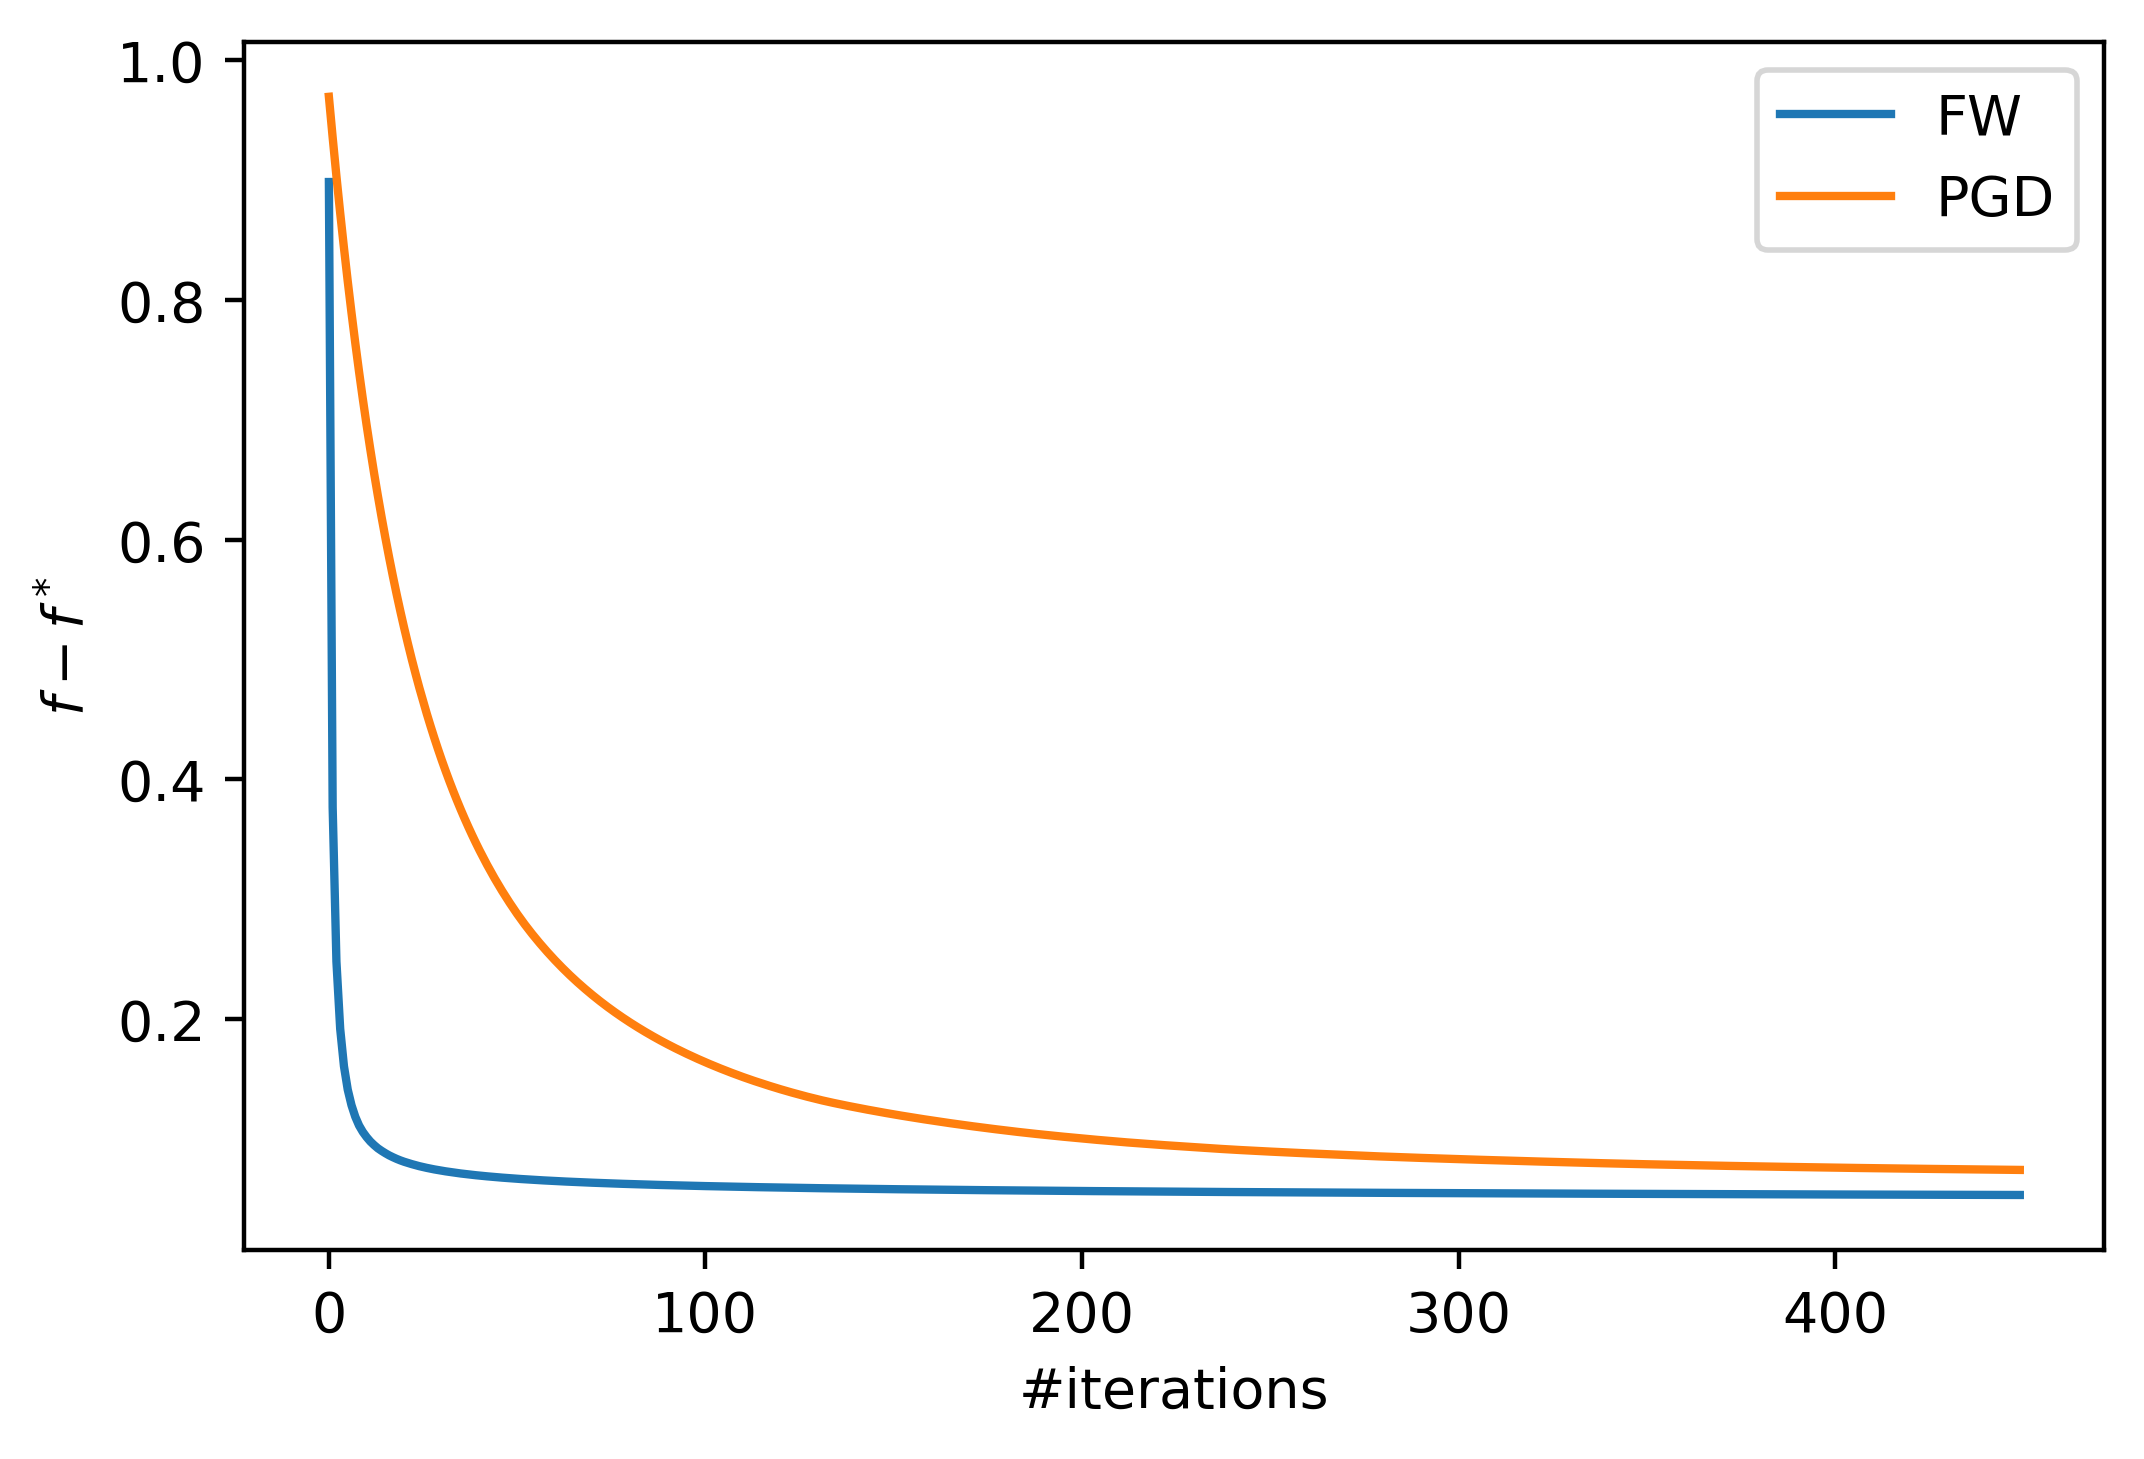

In [34]:
fig, ax1 = plt.subplots()
fig.set_dpi(400)
# ax1.set_title("epsilon = 10^-5")
# ax1.set_yscale('log')
ax1.plot(fw_img, label='FW')
ax1.plot(pgd_img, label='PGD')
ax1.set_xlabel('#iterations')
ax1.set_ylabel(r'$f-f^*$')
ax1.legend()

# Q4

In [15]:
d = 200

M = np.zeros((d, d))
for i in range(1, d - 1):
    M[i, i - 1] = -1
    M[i, i] = 2
    M[i, i + 1] = -1
M[0, 0] = 2
M[0, 1] = -1
M[d - 1, d - 2] = -1
M[d - 1, d - 1] = 2

b = np.zeros(d)
b[0] = 1


def f(x):
    return 0.5 * np.dot(x, M@ x) - np.dot(b, x)

def grad_f(x):
    return M @ x - b

def hess_f(x):
    return M

x_star = np.zeros(d)
x_star = np.linalg.solve(M, b)
f_star = f(x_star)

def noisy_grad_f(x, epsilon):
    xi = np.random.normal(0, 1, x.shape)
    return grad_f(x) + epsilon * xi

def stochastic_grad_f(x):
    xi = np.random.normal(0, 1, x.shape)
    return grad_f(x) + xi


In [16]:
def AGD(x0, L = 4, max_iter=2000, epsilon=0.01):

    # strongly convex
    loss = np.ones(max_iter)
    x = x0.copy()
    y = x0.copy()
    alpha = 1 / L
    lambda_prev = 0
    lambda_curr = 0
    beta = 0
    x_prev = x0
    x_curr = x0

    values = []
    for i in range(max_iter):
        y_curr = x_curr + beta * (x_curr - x_prev)
        x_prev = x_curr
        x_curr = y_curr - alpha * noisy_grad_f(y_curr, epsilon)
        lambda_curr = (1 + np.sqrt(1 + 4 * lambda_prev * lambda_prev)) / 2
        lambda_prev = lambda_curr
        beta = (lambda_prev - 1) / (lambda_curr + 1)

        loss[i] = np.abs(f(x_curr) - f(x_star))
        values.append(f(x_curr))

    return values, loss

def GD(x0, L=4, max_iter=2000, epsilon=0.01):
    loss = np.ones(max_iter)
    x = x0.copy()
    step_size = 1/L
    n_iter = 0
    values = np.ones(max_iter)

    while n_iter < max_iter:
        grad = noisy_grad_f(x, epsilon)
        x -= step_size * grad
        values[n_iter] = f(x)
        loss[n_iter] = f(x) - f(x_star)
        n_iter += 1

    return values, loss

def SGD(x0, L=4, max_iter=100):
    loss = np.ones(max_iter)
    x = x0.copy()
    n_iter = 0
    values = np.ones(max_iter)

    while n_iter < max_iter:
        alpha_k = 1 / (2 * L * np.sqrt(n_iter + 1))
        grad = stochastic_grad_f(x)
        x -= alpha_k * grad
        values[n_iter] = f(x)
        loss[n_iter] = f(x) - f(x_star)
        n_iter += 1

    return values, loss

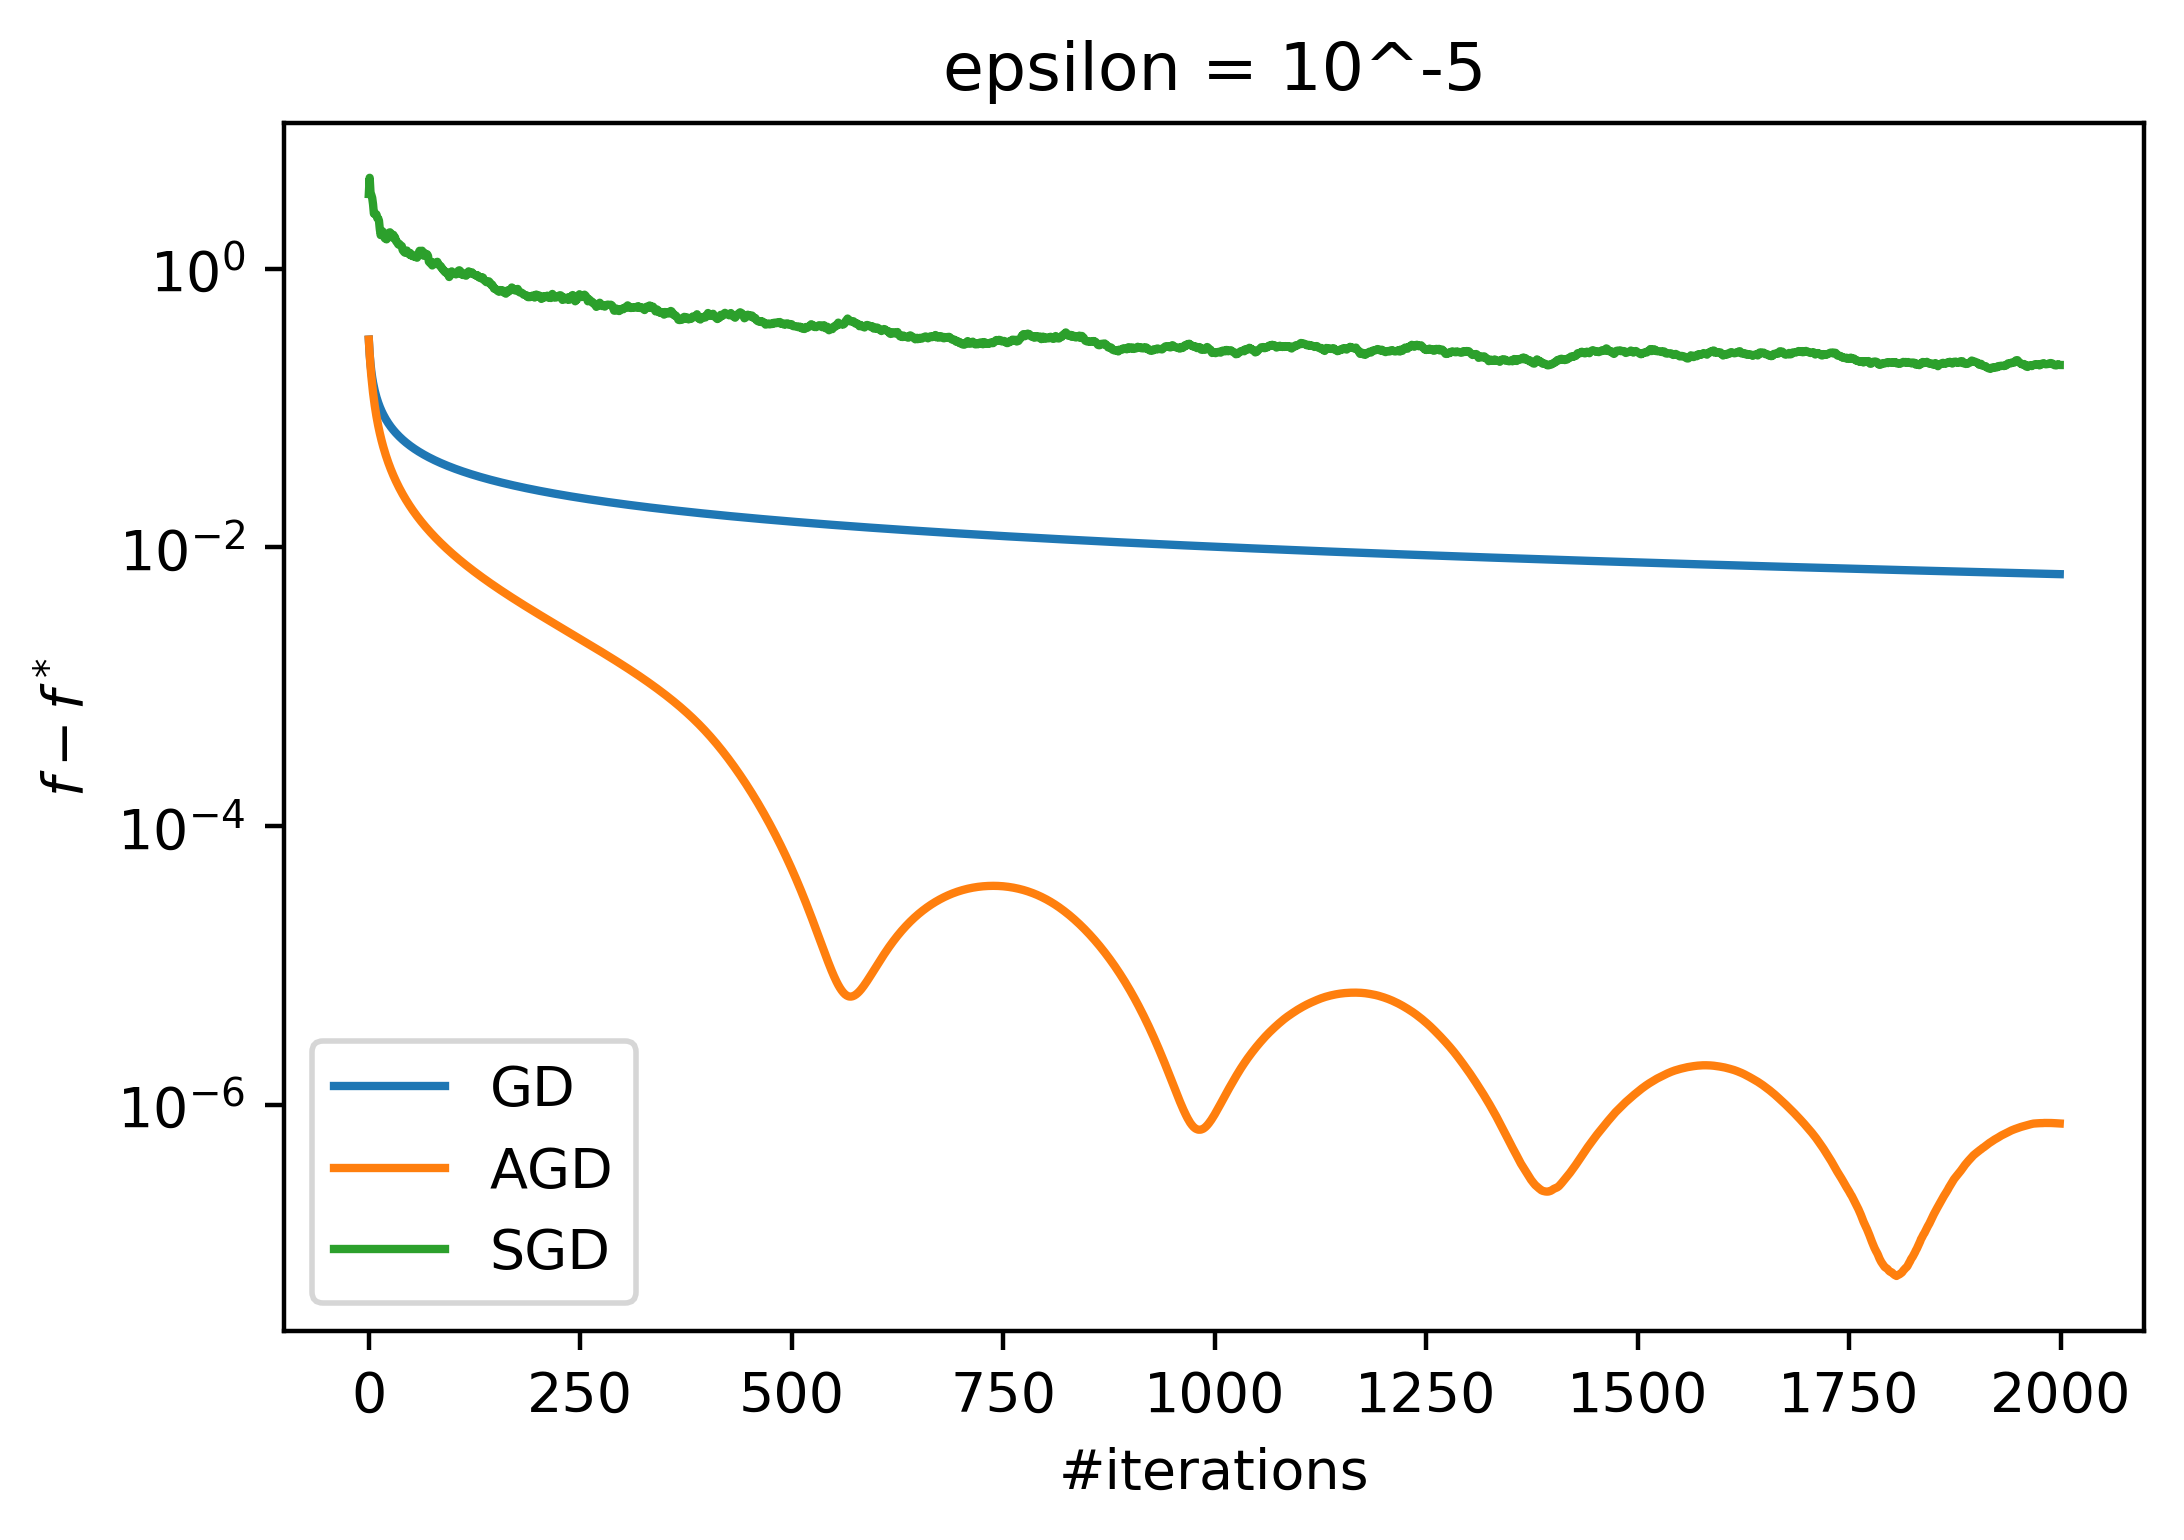

In [20]:
x0 = np.zeros(d)

_, lossGD = GD(x0, L = 4, max_iter = 2000, epsilon = 1e-5)
_, lossAGD = AGD(x0, L = 4, max_iter = 2000, epsilon = 1e-5)
_, lossSGD = SGD(x0, L = 4, max_iter=2000)

fig, ax1 = plt.subplots()
fig.set_dpi(400)
ax1.set_title("epsilon = 10^-5")
ax1.set_yscale('log')
ax1.plot(lossGD, label='GD')
ax1.plot(lossAGD, label='AGD')
ax1.plot(lossSGD, label='SGD')
ax1.set_xlabel('#iterations')
ax1.set_ylabel(r'$f-f^*$')
ax1.legend()

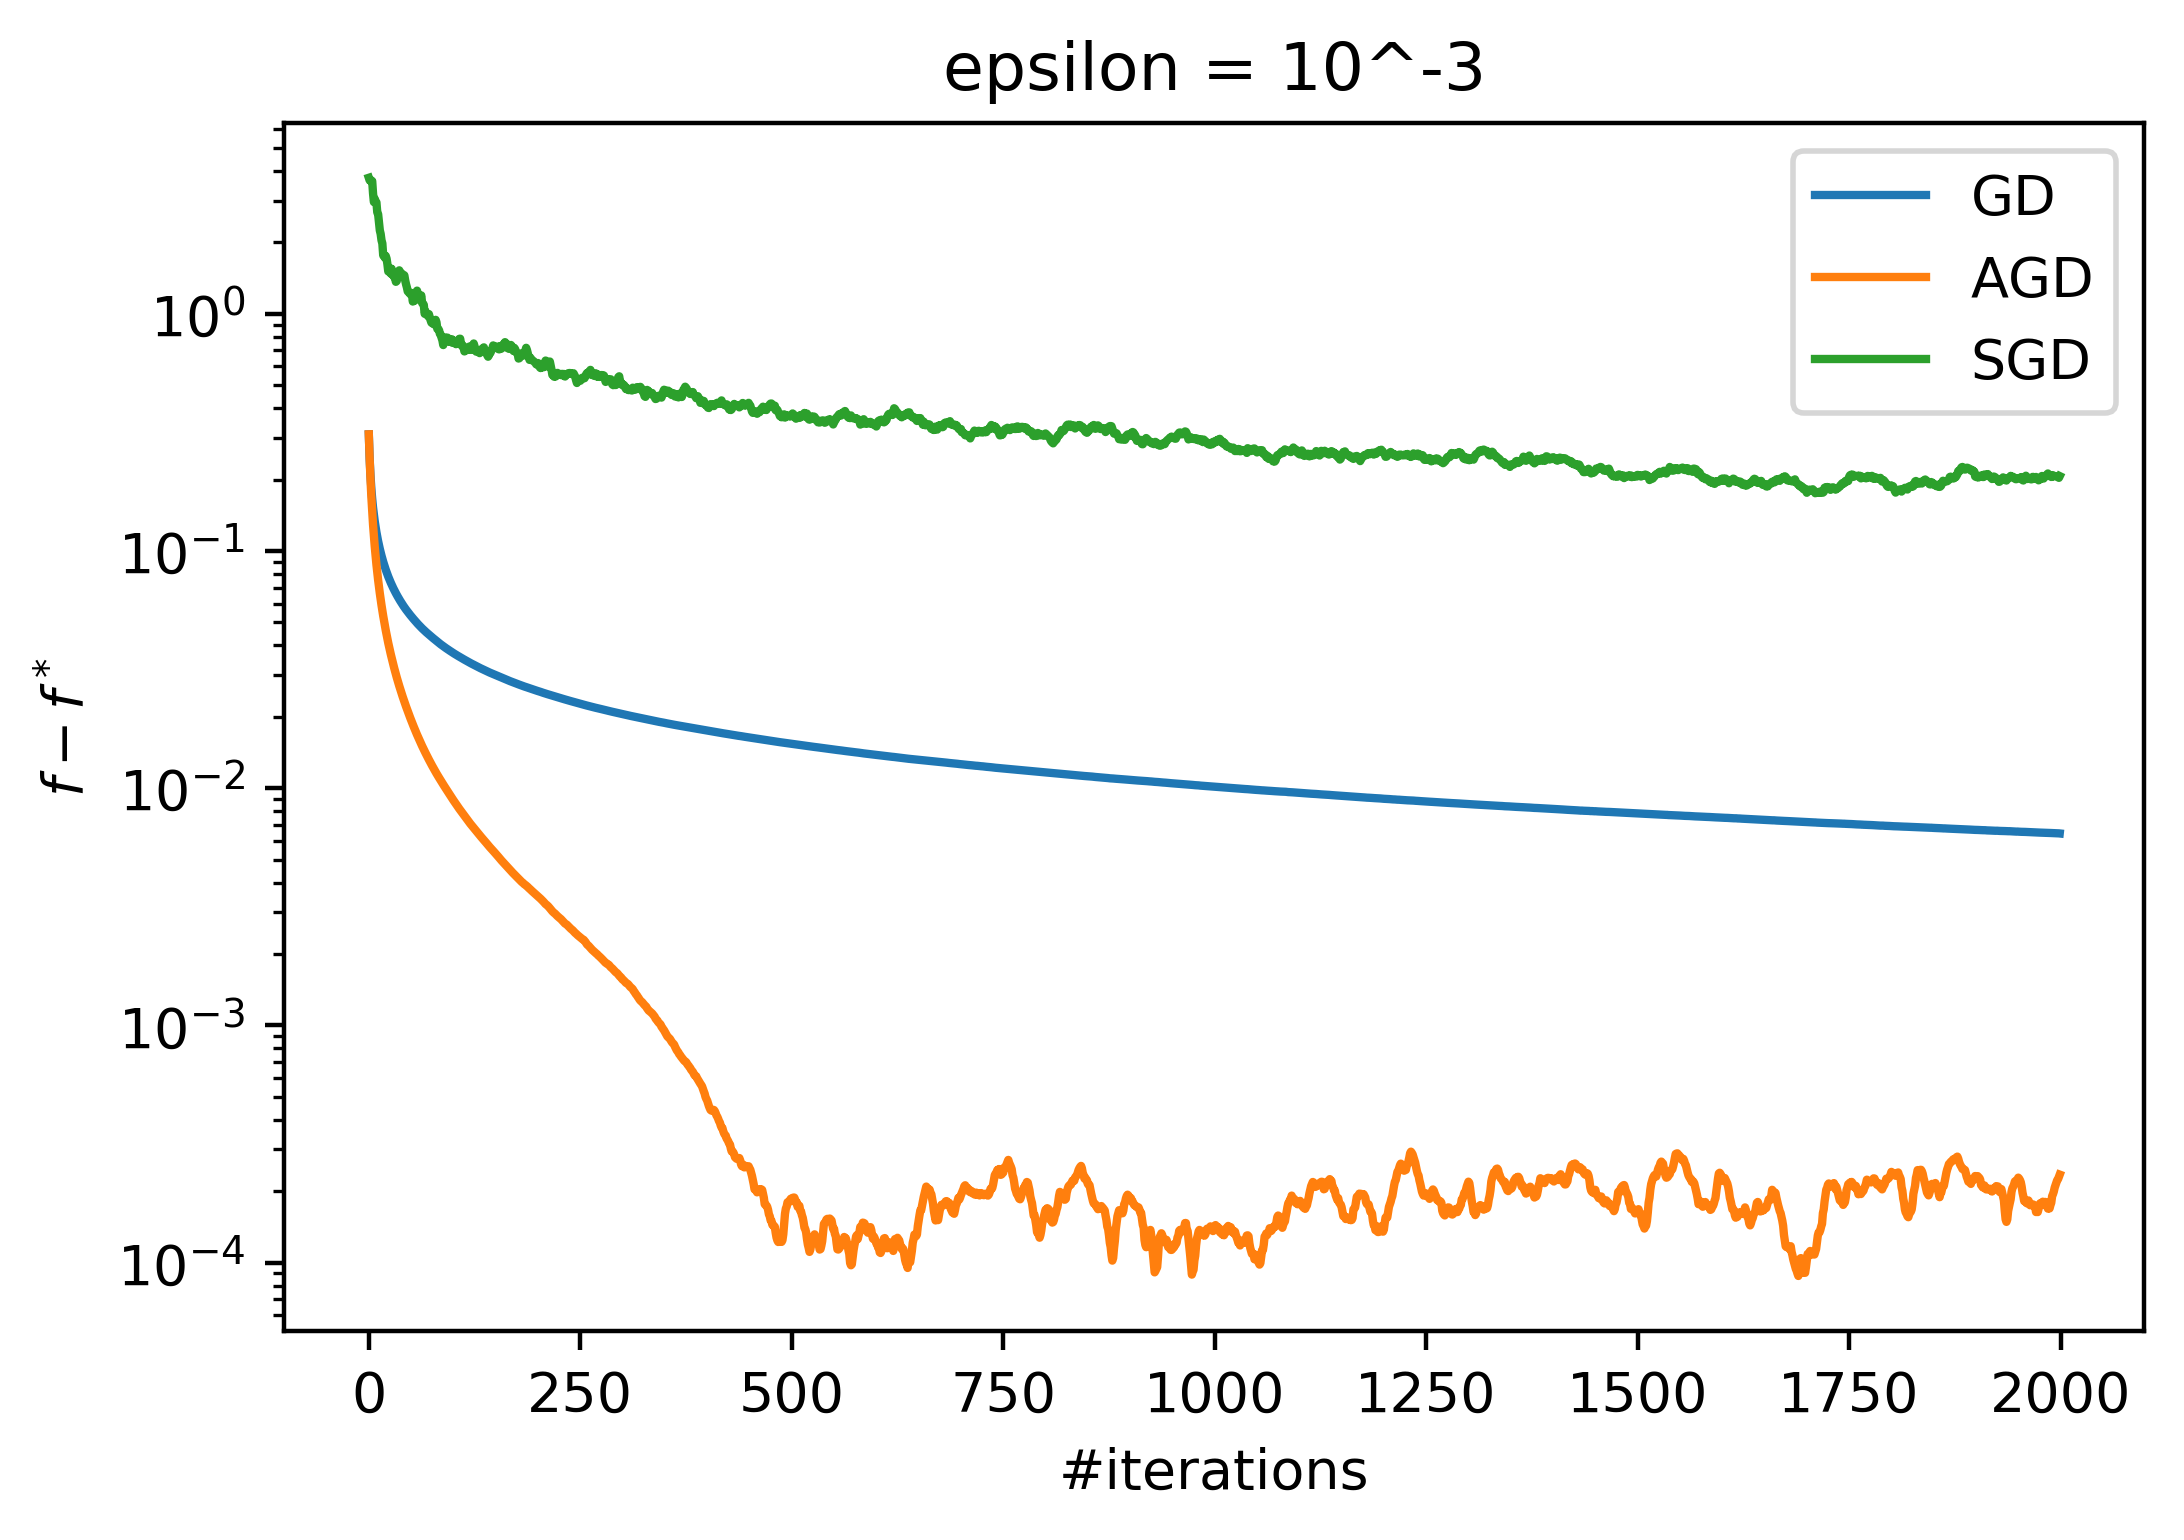

In [22]:
_, lossGD = GD(x0, L = 4, max_iter = 2000, epsilon = 1e-3)
_, lossAGD = AGD(x0, L = 4, max_iter = 2000, epsilon = 1e-3)
_, lossSGD = SGD(x0, L = 4, max_iter=2000)

fig, ax1 = plt.subplots()
fig.set_dpi(400)
ax1.set_title("epsilon = 10^-3")
ax1.set_yscale('log')
ax1.plot(lossGD, label='GD')
ax1.plot(lossAGD, label='AGD')
ax1.plot(lossSGD, label='SGD')
ax1.set_xlabel('#iterations')
ax1.set_ylabel(r'$f-f^*$')
ax1.legend()

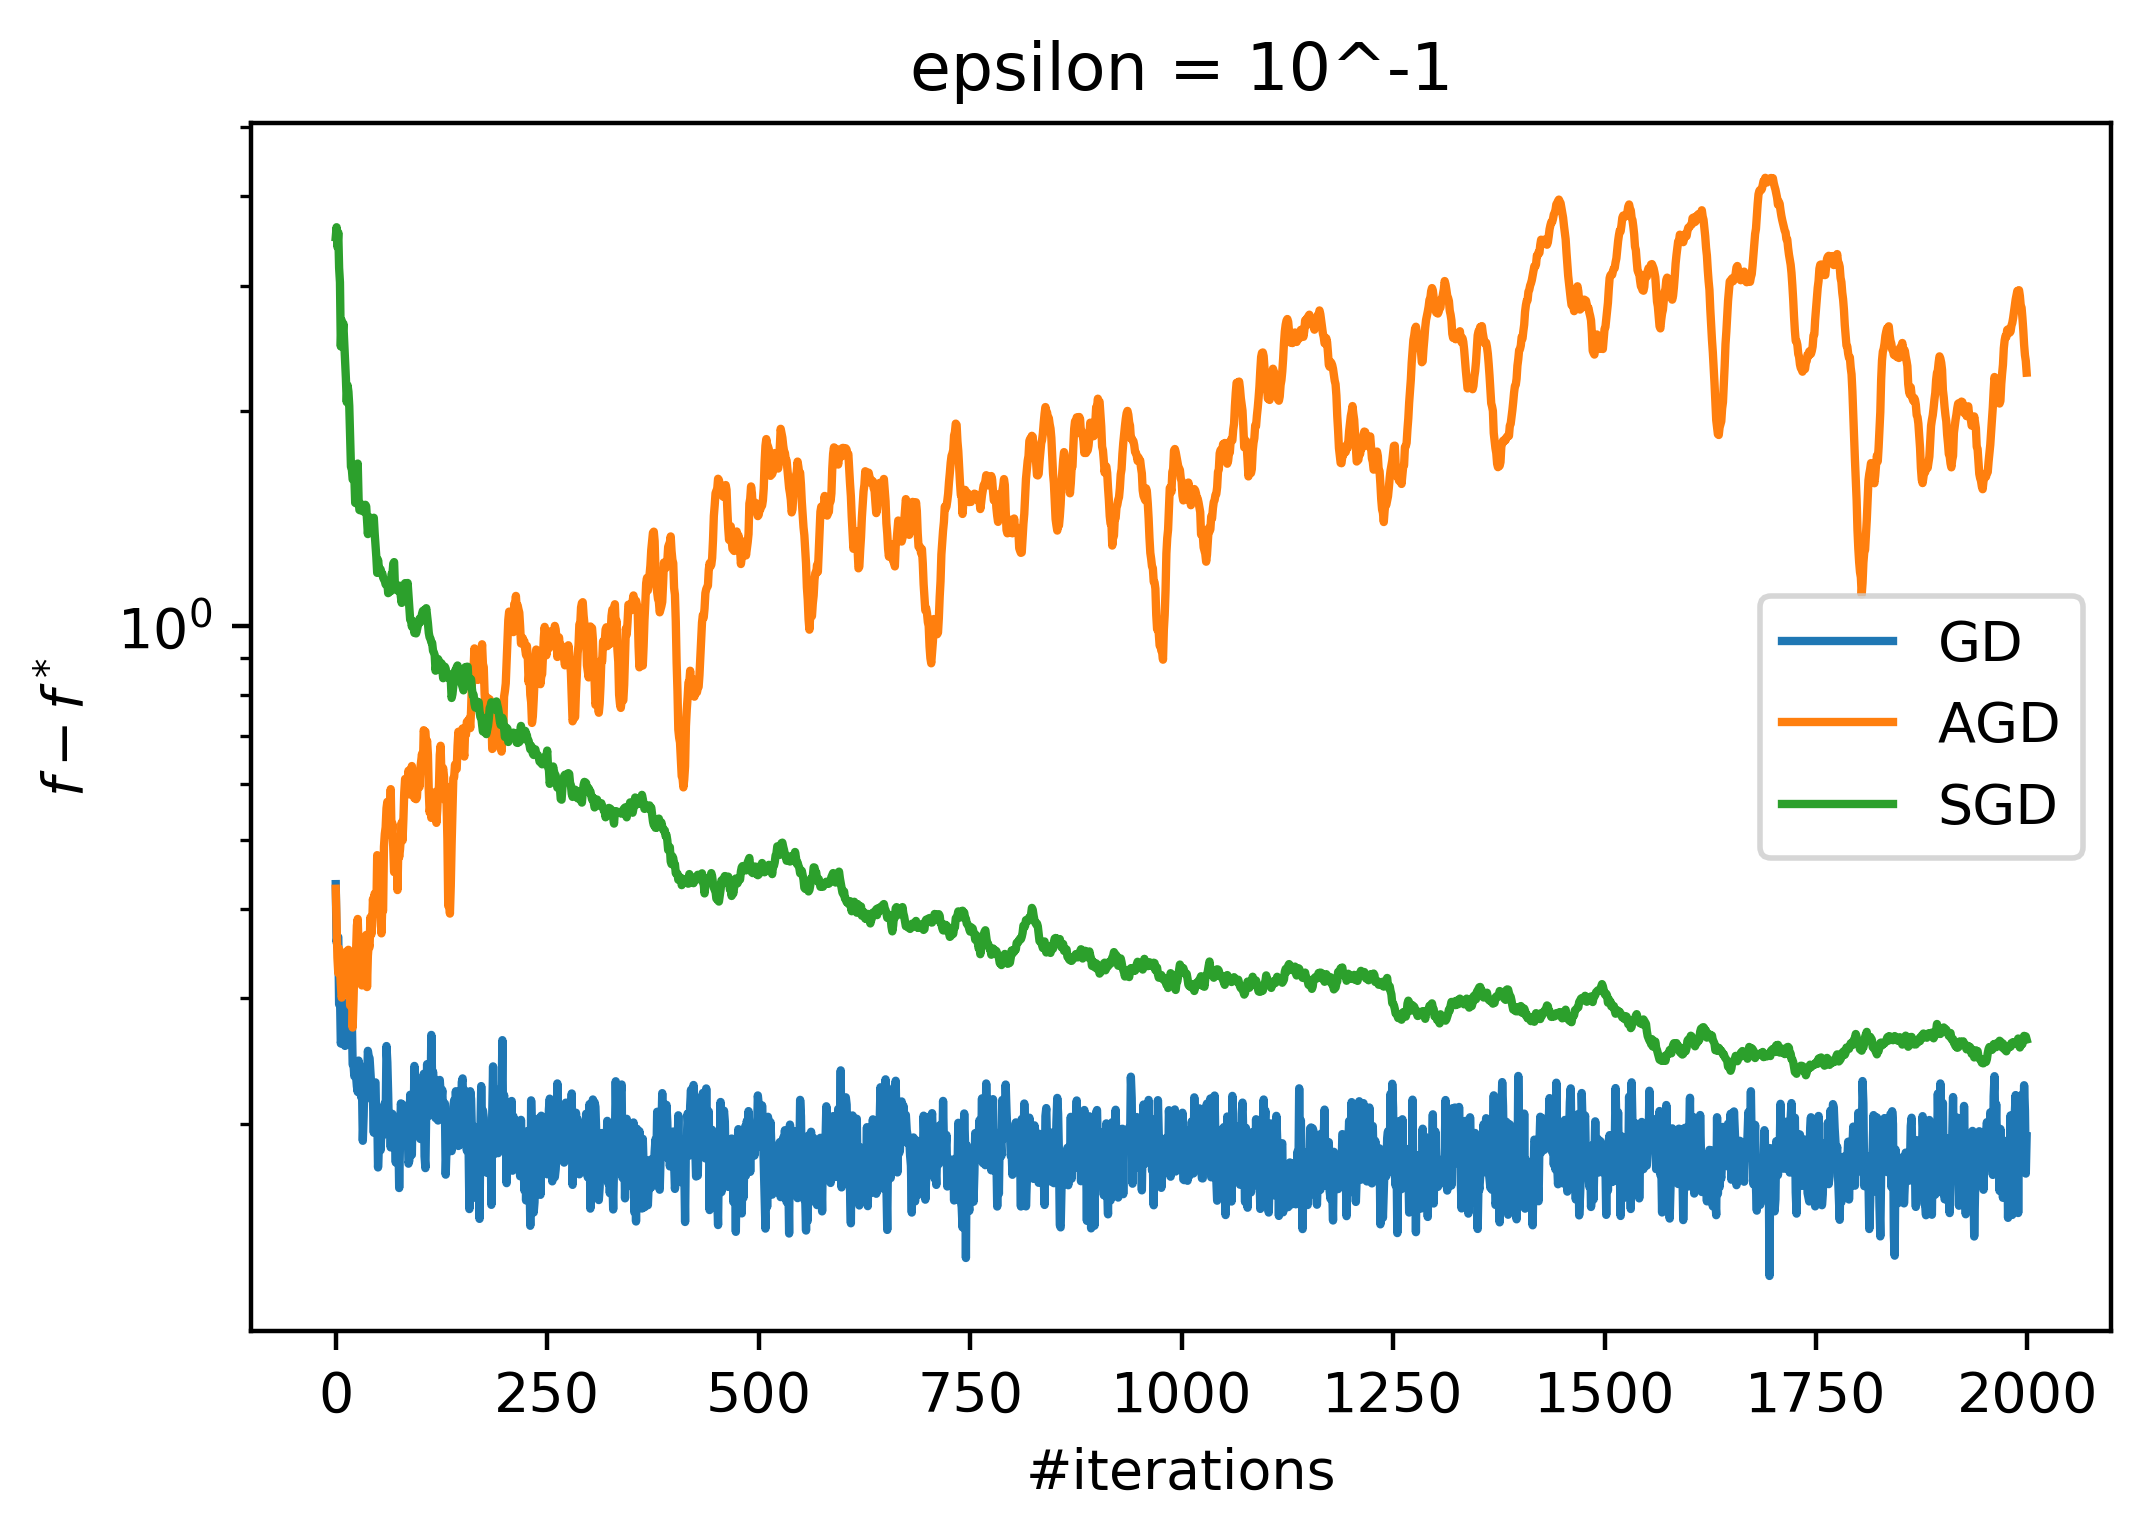

In [23]:
_, lossGD = GD(x0, L = 4, max_iter = 2000, epsilon = 0.1)
_, lossAGD = AGD(x0, L = 4, max_iter = 2000, epsilon = 0.1)
_, lossSGD = SGD(x0, L = 4, max_iter=2000)

fig, ax1 = plt.subplots()
fig.set_dpi(400)
ax1.set_title("epsilon = 10^-1")
ax1.set_yscale('log')
ax1.plot(lossGD, label='GD')
ax1.plot(lossAGD, label='AGD')
ax1.plot(lossSGD, label='SGD')
ax1.set_xlabel('#iterations')
ax1.set_ylabel(r'$f-f^*$')
ax1.legend()